In [7]:
import exifread
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import depth_pro

# Load Models

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon")
else:
    device = torch.device("cpu")
    print("Using CPU")

print("Loading Model...")
model = deeplabv3_resnet101(pretrained=False, num_classes=1, aux_loss=True) # add resnet101 backbone
model.load_state_dict(torch.load('best_pig_segmentation_model.pth', map_location=device)) # load the weight

model.to(device)
model.eval()

Using Apple Silicon
Loading Model...


/opt/anaconda3/envs/depth-pro/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/depth-pro/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Preprocessing

In [9]:
# Transform the image to match the training size
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# load the image
print("Loading an Image...")
input_image_path = 'internet4.webp' # real.jpg
input_image = Image.open(input_image_path).convert("RGB")
input_tensor = image_transforms(input_image).unsqueeze(0).to(device)

Loading an Image...


# Segmentation

In [10]:
# Segment the image
with torch.no_grad():
    output = model(input_tensor)['out']

# Get probabilities (confidence map)
probabilities = torch.sigmoid(output)  # values between 0 and 1
confidence_map = probabilities.squeeze(0).squeeze(0).cpu().numpy()

# Binary mask using a threshold
predicted_mask = (confidence_map > 0.7).astype(np.uint8)

# Resize both mask and confidence map to original size
original_size = input_image.size  # (width, height)
mask_resized = Image.fromarray((predicted_mask * 255).astype(np.uint8)).resize(original_size, Image.NEAREST)
mask_resized = np.array(mask_resized) / 255.0

confidence_resized = Image.fromarray((confidence_map * 255).astype(np.uint8)).resize(original_size, Image.BILINEAR)
confidence_resized = np.array(confidence_resized) / 255.0

# Create masked pig image (pig only, transparent/white background)
input_image_array = np.array(input_image)
masked_pig = input_image_array.copy()

# Apply mask - set background to white (or use alpha channel for transparency)
masked_pig[mask_resized < 0.5] = [255, 255, 255]  # White background

binary_mask_for_measurement = (mask_resized * 255).astype(np.uint8)


# Get pig length and widths

In [11]:
def measure_pig_length_and_widths(binary_mask, frac_shift=0.1, window_frac=0.1, visualize=True):
    """
    Measure the pig's main body length and approximate widths near the top and bottom
    based on PCA of the largest contour in a binary mask.

    Arg:
    binary_mask : np.ndarray
        Binary image (0 or 1 / 0 or 255) containing the pig segmentation.
    frac_shift : float
        Fraction of the length along the pig to measure the top/bottom width (default 0.1 = 10%).
    window_frac : float
        Fraction of the pig's length used to compute local width window (default 0.1 = 10%).
    visualize : bool
        Whether to display the annotated image.

    Returns:
    results : dict
        {
            "length": float,
            "width_top": float,
            "width_bottom": float,
            "annotated_image": np.ndarray
        }
    """
    # Ensure binary mask is uint8
    mask = (binary_mask > 0).astype(np.uint8)

    # Find largest contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the binary mask.")
    pig_contour = max(contours, key=cv2.contourArea)
    points = pig_contour.reshape(-1, 2).astype(np.float32)

    # PCA
    mean, eigenvectors = cv2.PCACompute(points, mean=np.array([]))
    center = mean[0]
    axis = eigenvectors[0] / np.linalg.norm(eigenvectors[0])  # main axis
    axis2 = eigenvectors[1] / np.linalg.norm(eigenvectors[1])  # perpendicular axis

    # Project points onto main axis to get endpoints
    proj = (points - center) @ axis
    min_proj, max_proj = proj.min(), proj.max()
    p1 = center + axis * min_proj
    p2 = center + axis * max_proj

    # Compute top/bottom sample points
    top_point = p1 + (p2 - p1) * frac_shift
    bottom_point = p2 - (p2 - p1) * frac_shift

    def local_width(sample_point, points, axis, axis2, window_frac):
        """Compute width along axis2 near sample_point."""
        length = np.linalg.norm(p2 - p1)
        window = length * window_frac

        proj_main = (points - sample_point) @ axis
        local_pts = points[np.abs(proj_main) <= window]

        if len(local_pts) < 2:
            return 0, sample_point, sample_point

        proj_perp = (local_pts - sample_point) @ axis2
        min_p, max_p = proj_perp.min(), proj_perp.max()
        p_start = sample_point + axis2 * min_p
        p_end = sample_point + axis2 * max_p
        width = np.linalg.norm(p_end - p_start)
        return width, p_start, p_end

    # Compute widths
    width_top, top_a, top_b = local_width(top_point, points, axis, axis2, window_frac)
    width_bottom, bot_a, bot_b = local_width(bottom_point, points, axis, axis2, window_frac)

    # Compute length
    length = np.linalg.norm(p2 - p1)

    # Draw visualization
    mask_rgb = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(mask_rgb, [pig_contour], -1, (0, 255, 0), 1)
    cv2.line(mask_rgb, tuple(p1.astype(int)), tuple(p2.astype(int)), (0, 0, 255), 2)  # main length
    cv2.line(mask_rgb, tuple(top_a.astype(int)), tuple(top_b.astype(int)), (255, 0, 0), 2)  # top width
    cv2.line(mask_rgb, tuple(bot_a.astype(int)), tuple(bot_b.astype(int)), (0, 165, 255), 2)  # bottom width

    if visualize:
        plt.imshow(cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB))
        plt.title("Pig Length and Local Widths")
        plt.axis("off")
        plt.show()

    return {
        "length": length,
        "width_top": width_top,
        "width_bottom": width_bottom,
        "annotated_image": mask_rgb
    }

In [12]:
# Measure pig dimensions (in pixels)
print("Measuring pig dimensions (in pixels)...")
measurements = measure_pig_length_and_widths(
    binary_mask_for_measurement,
    frac_shift=0.1,
    window_frac=0.1,
    visualize=False
)

# Print measurements
print(f"\nPig Measurements in pixel:")
print(f"Length: {measurements['length']:.2f} pixels")
print(f"Width (Top): {measurements['width_top']:.2f} pixels")
print(f"Width (Bottom): {measurements['width_bottom']:.2f} pixels")


Measuring pig dimensions (in pixels)...

Pig Measurements in pixel:
Length: 230.84 pixels
Width (Top): 59.40 pixels
Width (Bottom): 48.35 pixels


# Depth Prediction

focal length (px): 377.2723388671875

Pig Depth Measurements:
Mean depth: 0.99 meters
Minimum depth: 0.92 meters
Maximum depth: 1.35 meters


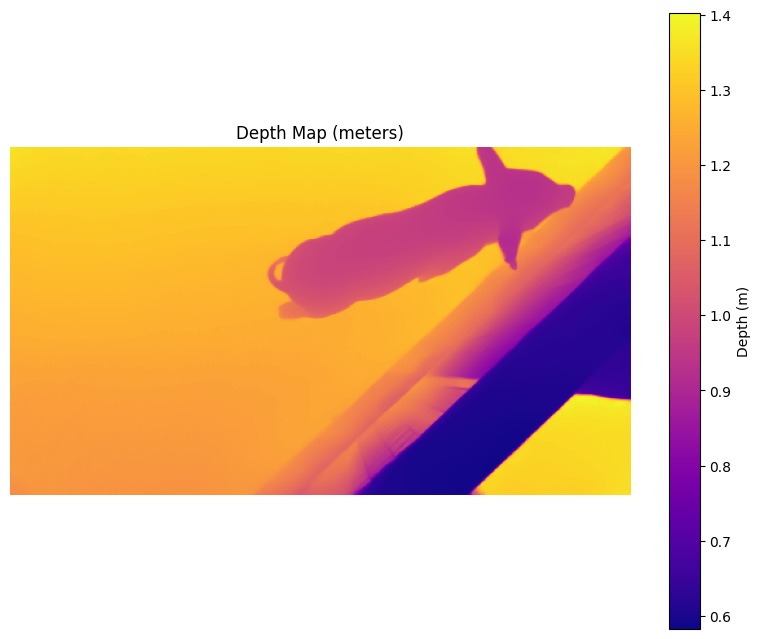

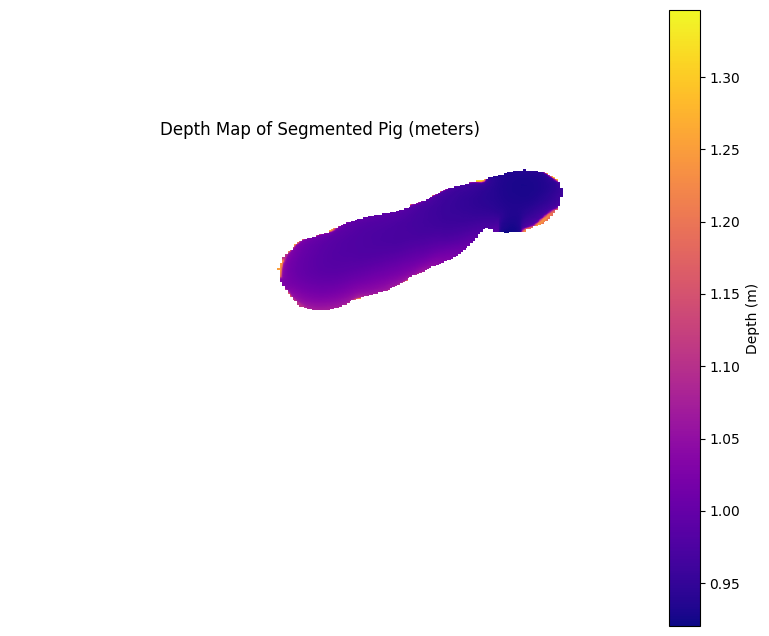

In [17]:
depth_model, transform = depth_pro.create_model_and_transforms()
depth_model.eval()


if torch.cuda.is_available():
    depth_model = depth_model.cuda()

image_rgb, _, f_px = depth_pro.load_rgb(input_image_path)
depth_input = transform(image_rgb)

prediction = depth_model.infer(depth_input, f_px=f_px)
depth = prediction["depth"]
depth_np = depth.squeeze().cpu().numpy()

focallength_px = prediction["focallength_px"]
print(f"focal length (px): {focallength_px.item()}")
# Create masked depth map using segmentation mask
# Resize mask to match depth map size if needed
mask_depth_size = cv2.resize(binary_mask_for_measurement, depth_np.shape[::-1])
masked_depth = depth_np.copy()
masked_depth[mask_depth_size == 0] = np.nan

# Calculate depth statistics for the segmented pig
mean_depth = np.nanmean(masked_depth)
min_depth = np.nanmin(masked_depth)
max_depth = np.nanmax(masked_depth)

print("\nPig Depth Measurements:")
print(f"Mean depth: {mean_depth:.2f} meters")
print(f"Minimum depth: {min_depth:.2f} meters")
print(f"Maximum depth: {max_depth:.2f} meters")

# Update the distance_mm in your object size calculation
distance_mm = min_depth * 1000  # Convert meters to mm

# Visualize depth map
plt.figure(figsize=(10, 8))
plt.imshow(depth_np, cmap="plasma")
plt.title("Depth Map (meters)")
plt.colorbar(label="Depth (m)")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(masked_depth, cmap="plasma")
plt.title("Depth Map of Segmented Pig (meters)")
plt.colorbar(label="Depth (m)")
plt.axis("off")
plt.show()

# Visualize

/var/folders/t8/ck7x549546b459855c3l7hn00000gn/T/ipykernel_47547/2518077861.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


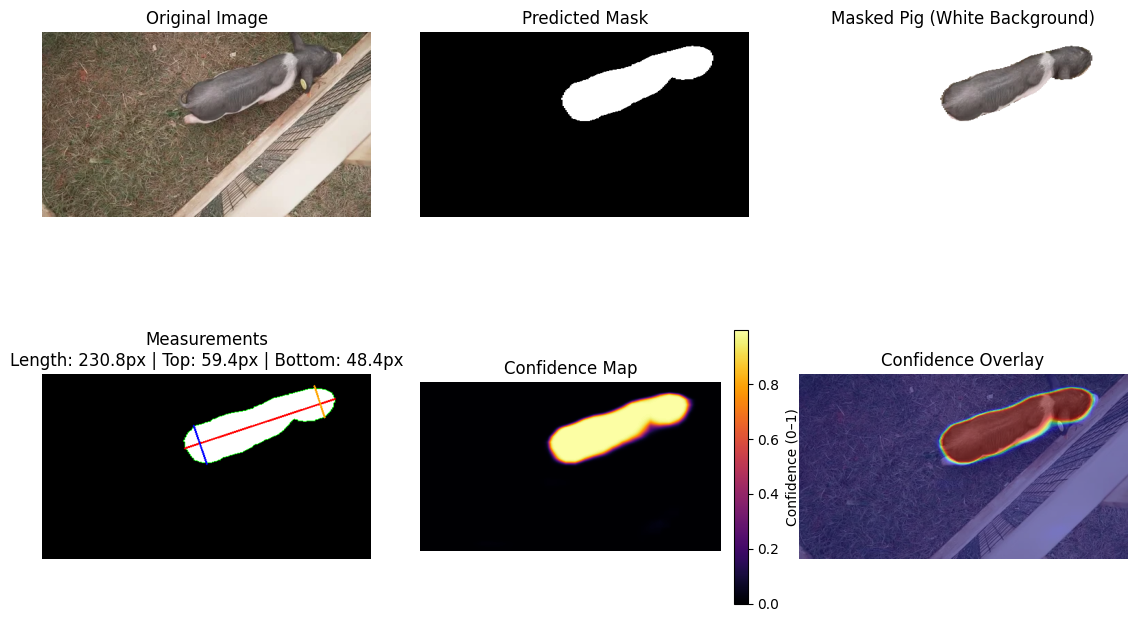

In [16]:
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, figure=fig, wspace=0.15, hspace=0.25)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(input_image)
ax1.set_title('Original Image')
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(mask_resized, cmap='gray')
ax2.set_title('Predicted Mask')
ax2.axis('off')

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(masked_pig)
ax3.set_title('Masked Pig (White Background)')
ax3.axis('off')

ax4 = fig.add_subplot(gs[1, 0])
ax4.imshow(cv2.cvtColor(measurements['annotated_image'], cv2.COLOR_BGR2RGB))
ax4.set_title(f"Measurements\nLength: {measurements['length']:.1f}px | "
              f"Top: {measurements['width_top']:.1f}px | "
              f"Bottom: {measurements['width_bottom']:.1f}px")
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 1])
im = ax5.imshow(confidence_resized, cmap='inferno')
ax5.set_title('Confidence Map')
ax5.axis('off')
plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04, label='Confidence (0–1)')

ax6 = fig.add_subplot(gs[1, 2])
ax6.imshow(input_image)
ax6.imshow(confidence_resized, cmap='jet', alpha=0.5)
ax6.set_title('Confidence Overlay')
ax6.axis('off')

plt.tight_layout()
plt.show()

# Get Metadata

In [ ]:

# Get image width
image_width = input_image.width
image_height = input_image.height 

# Open the image file for reading EXIF data
with open(input_image_path, 'rb') as img_file:
    tags = exifread.process_file(img_file)
    focal_length_raw = tags.get('EXIF FocalLength', 'Not available')
    focal_length_35mm_raw = tags.get('EXIF FocalLengthIn35mmFilm', 'Not available')
    
    # Convert focal length to float
    if focal_length_raw != 'Not available':
        focal_length = float(focal_length_raw.values[0])
    else:
        focal_length = 'Not available'
    
    # Convert 35mm focal length to int
    if focal_length_35mm_raw != 'Not available':
        focal_length_35mm = int(focal_length_35mm_raw.values[0])
    else:
        focal_length_35mm = 'Not available'

print(f"Image Width: {image_width}")
print(f"Image Height: {image_height}")
print(f"Focal Length: {focal_length} mm")
print(f"Focal Length (35mm equivalent): {focal_length_35mm} mm")


# Find object size

In [ ]:
def calculate_object_size(pixel_length, image_width_pixels, sensor_width_mm, focal_length_mm, distance_mm):
    """
    Calculate real-world object size from pixel measurements.
    
    Formula:
    1. pixel_size_mm = sensor_width_mm / image_width_pixels
    2. object_size_on_sensor_mm = 
    th x pixel_size_mm
    3. real_object_size_mm = (object_size_on_sensor_mm x distance_mm) / focal_length_mm
    
    Args:
        pixel_length: Length of object in pixels
        image_width_pixels: Image width in pixels
        sensor_width_mm: Camera sensor width in mm
        focal_length_mm: Focal length in mm
        distance_mm: Distance from camera to object in mm
    
    Returns:
        Real object size in mm
    """
    # Calculate pixel size in mm
    pixel_size_mm = sensor_width_mm / image_width_pixels
    
    # Calculate object size on sensor
    object_size_on_sensor_mm = pixel_length * pixel_size_mm
    
    # Calculate real object size using similar triangles
    real_object_size_mm = (object_size_on_sensor_mm * distance_mm) / focal_length_mm
    
    return real_object_size_mm

# Your data
image_width_pixels = image_width # Image width in pixels or height
image_height_pixels = image_height
focal_length_mm = focal_length # Xiaomi note 14 = 5.24 or from image = focal_length

####################################### change this########################################
sensor_width_mm = 7.68 # Example: Xiaomi Note 14 sensor width or height in mm
sensor_height_mm = 5.76
pixel_length = measurements['length'] # Measured length in pixels from the image

# You need to know the distance to the object
distance_mm = 1000  # From depth prediction model

object_size_mm = calculate_object_size(
    pixel_length=pixel_length,
    image_width_pixels=image_height_pixels, # image_width_pixels=image_height_pixels or image_width_pixels=image_width_pixels
    sensor_width_mm=sensor_height_mm,
    focal_length_mm=focal_length_mm,
    distance_mm=distance_mm
)

print(f"Real object size: {object_size_mm:.2f} mm ({object_size_mm/10:.2f} cm)")
